In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import itertools
import operator
from tqdm import tqdm

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import seaborn as sns
mallet_path = 'mallet-2.0.8/bin/mallet'

# for paralellization
from joblib import Parallel, delayed

%matplotlib inline

In [2]:
lemmatized_df = pd.read_csv("lemmatized_df.csv")
print(lemmatized_df.shape)
# remove na nan documents
lemmatized_df = lemmatized_df[lemmatized_df.lemmatized_desc ==
                              lemmatized_df.lemmatized_desc]
print(lemmatized_df.shape)

(103978, 3)
(102451, 3)


In [3]:
def get_doc_len(doc):
    split = doc.split()
    return len(split)


lemmatized_df["len_docs"] = lemmatized_df.lemmatized_desc.apply(get_doc_len)
lemmatized_df = lemmatized_df[lemmatized_df.len_docs >= 10]
print(lemmatized_df.shape)

(95648, 4)


In [4]:
lemmatized_df.reset_index(inplace=True)
lemmatized_df.drop("index", axis=1,inplace=True)
lemmatized_df.head()

,lemmatized_desc,bundle_id,description,len_docs
0,block engaging puzzle game simple distinctive ...,1000548274,1010 Block is an engaging puzzle game with a s...,37
1,hooked fish daily catch experience thrill catc...,1000773093,Get hooked with Rapala® Fishing - Daily Catch!...,68
2,cannon hero arrive join rocket boy save evil f...,1000958628,THE CANNON HERO HAS ARRIVED. Join Rocket Boy a...,49
3,time flagship news brand medium group bring la...,1000991178,"Hindustan Times, the flagship news brand of th...",68
4,chance delve construction build stuff game fee...,1001013071,This is your chance to delve into the world of...,85


In [5]:
# Create Dictionary
data_lemmatized = list(lemmatized_df["lemmatized_desc"].str.split())
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View Gensim creates a unique id for each word in the document.
# The produced corpus shown below is a mapping of
# (word_id, word_frequency).
print(corpus[1:2])

[[(9, 1), (22, 1), (25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 4), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 3), (37, 1), (38, 1), (39, 1), (40, 5), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 3), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1)]]


In [6]:
texts = lemmatized_df.description.values.tolist()
bundle_ids = lemmatized_df.bundle_id.values.tolist()
lemmatized_desc = lemmatized_df.lemmatized_desc.values.tolist()

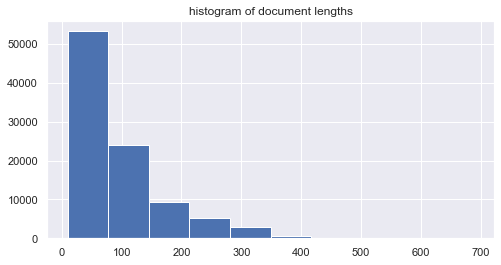

In [7]:
sns.set(rc={'figure.figsize': (8, 4)})
# fig, ax = plt.subplots()
title = lemmatized_df.len_docs.hist().set_title(r"histogram of document lengths")

In [8]:
print(data_lemmatized[1:2])
print(corpus[1:2])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

[['hooked', 'fish', 'daily', 'catch', 'experience', 'thrill', 'catch', 'variety', 'fish', 'immerse', 'beautiful', 'location', 'north', 'fill', 'tackle', 'box', 'authentic', 'gear', 'lure', 'big', 'improve', 'skill', 'fish', 'combination', 'tackle', 'retrieval', 'motion', 'lake', 'location', 'catch', 'big', 'fish', 'outing', 'compete', 'friend', 'angler', 'daily', 'challenge', 'tournament', 'real', 'fishing', 'real', 'realistic', 'fishing', 'dozen', 'real', 'compete', 'daily', 'fishing', 'tournament', 'angler', 'simple', 'intuitive', 'interface', 'control', 'unlimited', 'fishing', 'fish', 'timer', 'energy', 'restrict', 'return', 'sell', 'catch', 'collect', 'reward', 'seamless', 'water']]
[[(9, 1), (22, 1), (25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 4), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 3), (37, 1), (38, 1), (39, 1), (40, 5), (41, 4), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 3), (56, 1

[[('fill', 1),
  ('simple', 1),
  ('angler', 2),
  ('authentic', 1),
  ('beautiful', 1),
  ('big', 2),
  ('box', 1),
  ('catch', 4),
  ('challenge', 1),
  ('collect', 1),
  ('combination', 1),
  ('compete', 2),
  ('control', 1),
  ('daily', 3),
  ('dozen', 1),
  ('energy', 1),
  ('experience', 1),
  ('fish', 5),
  ('fishing', 4),
  ('friend', 1),
  ('gear', 1),
  ('hooked', 1),
  ('immerse', 1),
  ('improve', 1),
  ('interface', 1),
  ('intuitive', 1),
  ('lake', 1),
  ('location', 2),
  ('lure', 1),
  ('motion', 1),
  ('north', 1),
  ('outing', 1),
  ('real', 3),
  ('realistic', 1),
  ('restrict', 1),
  ('retrieval', 1),
  ('return', 1),
  ('reward', 1),
  ('seamless', 1),
  ('sell', 1),
  ('skill', 1),
  ('tackle', 2),
  ('thrill', 1),
  ('timer', 1),
  ('tournament', 2),
  ('unlimited', 1),
  ('variety', 1),
  ('water', 1)]]

In [65]:
alpha_list = [26]
topic_list = [17]
results = {}
models = {}

hyper_param_list = itertools.product(alpha_list, topic_list)
best_model = None
best_coherance = 0.0


for hyper_param in hyper_param_list:
    ldamallet = gensim.models.wrappers.LdaMallet(
        mallet_path, corpus=corpus, num_topics=hyper_param[1], iterations=1000,
        alpha=hyper_param[0], id2word=id2word, workers=5, prefix="saved_model/")

    # compute coherance score
    coherence_model_ldamallet = CoherenceModel(
        model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_ldamallet = coherence_model_ldamallet.get_coherence()

    results[hyper_param] = coherence_ldamallet
    models[hyper_param] = ldamallet
    if coherence_ldamallet > best_coherance:
        best_model = ldamallet
        best_coherance = coherence_ldamallet
        print('Best coherence Score: ', best_coherance)

Best coherence Score:  0.6416529716364853


In [66]:
print(results)
sum(best_model.alpha),best_model.num_topics

{(26, 17): 0.6416529716364853}


(26.000000000000007, 17)

In [67]:
# Show Topics
pprint(best_model.show_topics(formatted=False))

[(1,
  [('call', 0.021063257293140177),
   ('support', 0.016654118965709327),
   ('file', 0.014761835632994939),
   ('number', 0.014356708068453055),
   ('time', 0.011292930861605047),
   ('fast', 0.010497868016191599),
   ('easy', 0.010465795417332032),
   ('save', 0.009728125643562017),
   ('datum', 0.009074857445738226),
   ('speed', 0.008674793975753116)]),
 (11,
  [('service', 0.014423392611575861),
   ('account', 0.013127013280852796),
   ('money', 0.011521078827742892),
   ('purchase', 0.010631811385249792),
   ('offer', 0.010067107798350164),
   ('term', 0.008236042347140742),
   ('provide', 0.008065318006915274),
   ('business', 0.007905850216594781),
   ('site', 0.007389925012616716),
   ('job', 0.007382420646013399)]),
 (7,
  [('news', 0.06652525916410242),
   ('weather', 0.02399147571674683),
   ('live', 0.02334020454296498),
   ('late', 0.018590107449785398),
   ('sport', 0.018024477439528376),
   ('update', 0.017709795954948766),
   ('team', 0.01635547057827702),
   ('map

In [34]:
generate_viz = True

In [ ]:
if generate_viz is True:
    model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(
        best_model)
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
    pyLDAvis.save_html(vis, 'lda.html')
    vis

In [ ]:
vis

In [68]:
result_list = []


def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=texts,
                            bundle_ids=bundle_ids, lemmatized_desc=lemmatized_desc):
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        prev_prop_topic = 0.0
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0 or j == 1:  # => dominant topic
                if prev_prop_topic > 0 and ((prev_prop_topic-prop_topic)/prop_topic) > .1:
                    break

                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                result_list.append(
                    {'bundle_id': bundle_ids[i], 'topic_num': int(topic_num),
                     'topic_perc_contrib': round(prop_topic, 4), 'keywords': topic_keywords,
                     'lemmatized_desc': lemmatized_desc[i], 'description': texts[i]})
                prev_prop_topic = prop_topic
            else:
                break

In [69]:
format_topics_sentences(
    ldamodel=best_model, corpus=corpus, texts=texts, bundle_ids=bundle_ids,
    lemmatized_desc=lemmatized_desc)
df_topic_sents_keywords = pd.DataFrame(result_list)

In [70]:
print(df_topic_sents_keywords.shape)
df_topic_sents_keywords.head(10)

(101775, 6)


,bundle_id,topic_num,topic_perc_contrib,keywords,lemmatized_desc,description
0,1000548274,3,0.3823,"game, play, level, player, mode, fun, card, ma...",block engaging puzzle game simple distinctive ...,1010 Block is an engaging puzzle game with a s...
1,1000773093,4,0.3260,"collect, character, map, build, earn, coin, it...",hooked fish daily catch experience thrill catc...,Get hooked with Rapala® Fishing - Daily Catch!...
2,1000958628,8,0.3463,"game, hero, city, robot, fight, battle, super,...",cannon hero arrive join rocket boy save evil f...,THE CANNON HERO HAS ARRIVED. Join Rocket Boy a...
3,1000991178,7,0.5316,"news, weather, live, late, sport, update, team...",time flagship news brand medium group bring la...,"Hindustan Times, the flagship news brand of th..."
4,1001013071,9,0.5093,"game, drive, truck, simulator, parking, city, ...",chance delve construction build stuff game fee...,This is your chance to delve into the world of...
5,1001387844,3,0.4526,"game, play, level, player, mode, fun, card, ma...",love blackjack play blackjack game store fuss ...,Do you love Blackjack? Play the best FREE Blac...
6,1001425491,10,0.3051,"car, game, race, racing, bike, stunt, drive, t...",play drift game store unique car fast furious ...,Play the #1 drifting game on the App Store wit...
7,1001455591,8,0.4607,"game, hero, city, robot, fight, battle, super,...",epic zombie hibernate year ago ground construc...,An Epic Come back of the Zombies hibernating f...
8,1001498175,2,0.6610,"girl, design, dress, fun, play, color, baby, s...",royal mess queen birthday party tonight ready ...,~~> What a royal mess! The Queen’s birthday pa...
9,1001538662,7,0.5585,"news, weather, live, late, sport, update, team...",fan club late news fixture result check match ...,The Fan App for Stevenage FC is the best way t...


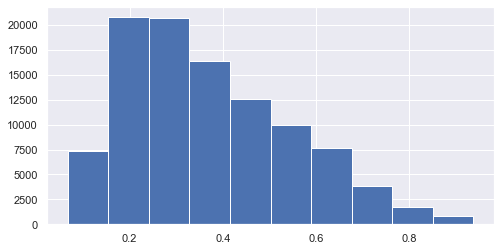

In [71]:
df_topic_sents_keywords.to_csv("bundle_id_topic.csv",index=False)
df_topic_sents_keywords.topic_perc_contrib.hist()

### Topic distribution across documents

In [72]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['topic_num'].value_counts()
# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)


In [73]:
def get_unique_key_words(group):
    return pd.Series({"keywords":group["keywords"].iloc[0]})

key_words=df_topic_sents_keywords.groupby("topic_num").apply(get_unique_key_words)
key_words.reset_index(inplace=True)

In [74]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_counts, topic_contribution], axis=1)
# Change Column names
df_dominant_topics.columns = ['Num_Documents', 'Perc_Documents']
# Show
df_dominant_topics["topic_num"] = df_dominant_topics.index
df_dominant_topics.reset_index(inplace=True)
df_dominant_topics.drop(["index"], axis=1, inplace=True)
df_dominant_topics = df_dominant_topics.merge(
    key_words, how="inner", on="topic_num")
df_dominant_topics.sort_values("Num_Documents", ascending=False)
df_dominant_topics

,Num_Documents,Perc_Documents,topic_num,keywords
0,11352,0.1115,3,"game, play, level, player, mode, fun, card, ma..."
1,9298,0.0914,13,"word, learn, question, test, language, book, a..."
2,7400,0.0727,11,"service, account, money, purchase, offer, term..."
3,7281,0.0715,1,"call, support, file, number, time, fast, easy,..."
4,7275,0.0715,16,"video, music, radio, song, listen, favorite, s..."
5,7024,0.0690,7,"news, weather, live, late, sport, update, team..."
6,6453,0.0634,4,"collect, character, map, build, earn, coin, it..."
7,5892,0.0579,15,"photo, image, share, picture, love, frame, fri..."
8,5608,0.0551,2,"girl, design, dress, fun, play, color, baby, s..."
9,5508,0.0541,8,"game, hero, city, robot, fight, battle, super,..."


In [75]:
df_dominant_topics.to_csv("df_dominant_topics.csv", index=False)

### Save the model

In [76]:
help(best_model)

Help on LdaMallet in module gensim.models.wrappers.ldamallet object:

class LdaMallet(gensim.utils.SaveLoad, gensim.models.basemodel.BaseTopicModel)
 |  LdaMallet(mallet_path, corpus=None, num_topics=100, alpha=50, id2word=None, workers=4, prefix=None, optimize_interval=0, iterations=1000, topic_threshold=0.0, random_seed=0)
 |  
 |  Python wrapper for LDA using `MALLET <http://mallet.cs.umass.edu/>`_.
 |  
 |  Communication between MALLET and Python takes place by passing around data files on disk
 |  and calling Java with subprocess.call().
 |  
 |  Warnings
 |  --------
 |  This is **only** python wrapper for `MALLET LDA <http://mallet.cs.umass.edu/>`_,
 |  you need to install original implementation first and pass the path to binary to ``mallet_path``.
 |  
 |  Method resolution order:
 |      LdaMallet
 |      gensim.utils.SaveLoad
 |      gensim.models.basemodel.BaseTopicModel
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __getitem__(self, bow, iterations=100)
 

In [77]:
from datetime import date
date = str(date.today())
best_model.save(f"saved_model/topic_model_{date}")

In [78]:
loaded_model = gensim.models.wrappers.LdaMallet.load(
    f"saved_model/topic_model_{date}")

In [79]:
test_df = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(loaded_model[corpus[:10]]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = loaded_model.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            test_df = test_df.append(pd.Series(
                [int(topic_num), round(prop_topic, 4), topic_keywords]), ignore_index=True)
        else:
            break
test_df.columns = ['Dominant_Topic',
                          'Perc_Contribution', 'Topic_Keywords']
test_df

,Dominant_Topic,Perc_Contribution,Topic_Keywords
0,3.0,0.3823,"game, play, level, player, mode, fun, card, ma..."
1,4.0,0.3260,"collect, character, map, build, earn, coin, it..."
2,8.0,0.3463,"game, hero, city, robot, fight, battle, super,..."
3,7.0,0.5316,"news, weather, live, late, sport, update, team..."
4,9.0,0.5093,"game, drive, truck, simulator, parking, city, ..."
5,3.0,0.4526,"game, play, level, player, mode, fun, card, ma..."
6,10.0,0.3051,"car, game, race, racing, bike, stunt, drive, t..."
7,8.0,0.4607,"game, hero, city, robot, fight, battle, super,..."
8,2.0,0.6610,"girl, design, dress, fun, play, color, baby, s..."
9,7.0,0.5585,"news, weather, live, late, sport, update, team..."
